In [112]:
import pandas as pd
import numpy as np
from juanFunciones import *
import seaborn as sns

In [113]:
types = {
 "event" : "category", 
 "person" : "category", 
 "url" : "category", 
 "sku" : "category", 
 "model" : "category", 
 "condition" : "category", 
 "storage" : "category", 
 "color" : "category", 
 "staticpage" : "category", 
 "campaign_source" : "category", 
 "search_engine" : "category", 
 "channel" : "category", 
 "new_vs_returning" : "category", 
 "city" : "category", 
 "region" : "category", 
 "country" : "category", 
 "device_type" : "category", 
 "screen_resolution" : "category", 
 "operating_system_version" : "category", 
 "browser_version" : "category",
    "os" : "category",
    "model_brand": "category",
    "label":"category"
}

In [114]:
train_df = pd.read_csv("all/events_up_to_01062018.csv", parse_dates=["timestamp"], dtype=types).rename(columns={"Unnamed: 0": "index"})

/home/tbotalla/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [115]:
train_df.head(2)

timestamp           event    person  url     sku  \
0 2018-05-18 00:11:59  viewed product  4886f805  NaN  9288.0   
1 2018-05-18 00:11:27  viewed product  ad93850f  NaN   304.0   

                     model  condition storage           color skus  \
0  Samsung Galaxy J7 Prime  Excelente    32GB         Dourado  NaN   
1                iPhone 5s  Muito Bom    32GB  Cinza espacial  NaN   

        ...       search_engine channel new_vs_returning city region country  \
0       ...                 NaN     NaN              NaN  NaN    NaN     NaN   
1       ...                 NaN     NaN              NaN  NaN    NaN     NaN   

  device_type screen_resolution operating_system_version browser_version  
0         NaN               NaN                      NaN             NaN  
1         NaN               NaN                      NaN             NaN  

[2 rows x 23 columns]

In [116]:
train_df['person'].value_counts().head(2)

c76b8417    4438
ffee0f18    3458
Name: person, dtype: int64

In [117]:
train_df.columns

Index(['timestamp', 'event', 'person', 'url', 'sku', 'model', 'condition',
       'storage', 'color', 'skus', 'search_term', 'staticpage',
       'campaign_source', 'search_engine', 'channel', 'new_vs_returning',
       'city', 'region', 'country', 'device_type', 'screen_resolution',
       'operating_system_version', 'browser_version'],
      dtype='object')

In [118]:
filteredDf(train_df, 'conversion').head(2)

timestamp       event    person     sku      model condition  \
195 2018-05-18 01:12:20  conversion  49c19e32  2683.0  iPhone 5c       Bom   
234 2018-05-18 01:05:23  conversion  49c19e32  2683.0  iPhone 5c       Bom   

    storage color skus  
195    16GB  Rosa  NaN  
234    16GB  Rosa  NaN

In [119]:
persons = train_df['person'].drop_duplicates().to_frame()

In [120]:
print(len(persons['person'].value_counts()))
print(len(persons))

38829
38829


# Sesiones

In [121]:
from juanFunciones import generateSessions as genSes
def generar_sesiones(df):
    sessions = genSes(df, "45 min")
    df["session_num"] = sessions
    df.head(1)
    
generar_sesiones(train_df)

/home/tbotalla/workspace/orga2018/TP2/juanFunciones.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  nextEvents.loc[nextEvents.index[-1]+1] = ev


Time Difference 45 min


In [122]:
# Features de sesiones
def add_session_features(df, persons):
    # Agrega columna con cantidad de sesiones por persona
    df['cant_sesiones'] = df.groupby(['person'])['session_num'].transform('sum')
    # Duracion sesiones
    sessions_features = df.groupby(['person']).agg({'event':'count', 'timestamp':['min','max']})
    sessions_features.columns = ['cant_eventos', 'min_timestamp', 'max_timestamp']
    sessions_features['duracion_sesion'] = ((sessions_features['max_timestamp']) - sessions_features['min_timestamp']).astype('timedelta64[s]')
    sessions_features.drop(['min_timestamp', 'max_timestamp'], axis=1, inplace=True)
    sessions_features.reset_index(inplace=True)
    persons = pd.merge(persons, sessions_features, left_on='person', right_on='person')
    return persons

persons = add_session_features(train_df, persons)

In [123]:
print(persons.shape)

(38829, 3)


In [124]:
persons.columns

Index(['person', 'cant_eventos', 'duracion_sesion'], dtype='object')

In [125]:
persons.head(1)

person  cant_eventos  duracion_sesion
0  4886f805             9           1388.0

# Features basados en las ultimas dos semanas

In [126]:
date_max = max(train_df['timestamp'])
print('Fecha maxima:', date_max)

Fecha maxima: 2018-05-31 23:59:59


In [127]:
# Chequeo previo para verificar no haber perdido datos
print('Cantidad personas:', len(train_df['person'].value_counts()))
print('Cantidad registros:', len(train_df))

Cantidad personas: 38829
Cantidad registros: 2341681


** Duracion desde el primer evento del usuario **

In [128]:
def durations_since_first_event(df, persons):  
    timestamp_primer_evento = df.groupby(['person']).agg({'timestamp':'min'})
    timestamp_primer_evento.columns = ['time_since_first_event']
    timestamp_primer_evento['time_since_first_event'] = (date_max - timestamp_primer_evento['time_since_first_event'])
    timestamp_primer_evento['days_since_first_event'] = timestamp_primer_evento['time_since_first_event'].astype('timedelta64[D]').astype(int)
    timestamp_primer_evento['hours_since_first_event'] = timestamp_primer_evento['time_since_first_event'].astype('timedelta64[h]').astype(int)
    timestamp_primer_evento['minutes_since_first_event'] = timestamp_primer_evento['time_since_first_event'].astype('timedelta64[m]').astype(int)
    timestamp_primer_evento.reset_index(inplace=True)
    timestamp_primer_evento.drop(['time_since_first_event'], axis=1, inplace=True)
    persons = pd.merge(persons, timestamp_primer_evento, left_on='person', right_on='person')
    return persons

persons = durations_since_first_event(train_df, persons)

** Duracion desde ultimo evento del usuario **

In [129]:
def durations_since_last_event(df, persons):
    timestamp_ultimo_evento = df.groupby(['person']).agg({'timestamp':'max'})
    timestamp_ultimo_evento.columns = ['time_since_last_event']
    timestamp_ultimo_evento['time_since_last_event'] = (date_max - timestamp_ultimo_evento['time_since_last_event'])
    timestamp_ultimo_evento['days_since_last_event'] = timestamp_ultimo_evento['time_since_last_event'].astype('timedelta64[D]').astype(int)
    timestamp_ultimo_evento['hours_since_last_event'] = timestamp_ultimo_evento['time_since_last_event'].astype('timedelta64[h]').astype(int)
    timestamp_ultimo_evento['minutes_since_last_event'] = timestamp_ultimo_evento['time_since_last_event'].astype('timedelta64[m]').astype(int)
    timestamp_ultimo_evento.reset_index(inplace=True)
    timestamp_ultimo_evento.drop(['time_since_last_event'], axis=1, inplace=True)
    persons = pd.merge(persons, timestamp_ultimo_evento, left_on='person', right_on='person')
    return persons

persons = durations_since_last_event(train_df, persons)

In [130]:
def features_last_week(df, persons):
    events_last_week = df[(date_max - df['timestamp']) < pd.Timedelta(days=7)]
    count_events_last_week = events_last_week.groupby(['person']).agg({'event':'count'})
    count_events_last_week.columns = ['count_events_last_week']
    count_events_last_week.reset_index(inplace=True)
    persons = pd.merge(persons, count_events_last_week, left_on='person', right_on='person', how='left')
    persons['count_events_last_week'] = persons['count_events_last_week'].fillna(0).astype(int)
    
    conversions_last_week = events_last_week[events_last_week['event'] == 'conversion']
    conversions_last_week = conversions_last_week.groupby(['person']).agg({'event':'count'})
    conversions_last_week.columns = ['count_conversions_last_week']
    conversions_last_week.reset_index(inplace=True)
    persons = pd.merge(persons, conversions_last_week, left_on='person', right_on='person', how='left')
    persons['count_conversions_last_week'] = persons['count_conversions_last_week'].fillna(0).astype(int)
    
    return persons

persons = features_last_week(train_df, persons)

In [131]:
# Chequeo posterior para verificar no haber perdido datos
print('Cantidad personas:', len(train_df['person'].value_counts()))
print('Cantidad registros:', len(train_df))

Cantidad personas: 38829
Cantidad registros: 2341681


In [132]:
persons.head(1)

person  cant_eventos  duracion_sesion  days_since_first_event  \
0  4886f805             9           1388.0                      13   

   hours_since_first_event  minutes_since_first_event  days_since_last_event  \
0                      335                      20152                     13   

   hours_since_last_event  minutes_since_last_event  count_events_last_week  \
0                     335                     20129                       0   

   count_conversions_last_week  
0                            0

In [133]:
persons.columns

Index(['person', 'cant_eventos', 'duracion_sesion', 'days_since_first_event',
       'hours_since_first_event', 'minutes_since_first_event',
       'days_since_last_event', 'hours_since_last_event',
       'minutes_since_last_event', 'count_events_last_week',
       'count_conversions_last_week'],
      dtype='object')

**Ocurrencias de modelo, almacenamiento, condicion y color mas vistos**

In [134]:
def count_most_common_model_views(df, persons):    
    viewed_product_events = filteredDf(df, 'viewed product')
    viewed_product_events['model'] = viewed_product_events['model'].astype(object)
    count_most_commont_model_views = viewed_product_events.groupby(['person'])['model'].agg(lambda x:x.value_counts().max())
    count_most_commont_model_views = pd.DataFrame(count_most_commont_model_views)
    count_most_commont_model_views.fillna(0, inplace=True)
    count_most_commont_model_views['model'] = count_most_commont_model_views['model'].astype(int)
    count_most_commont_model_views.columns = ['count_most_common_model_views']
    count_most_commont_model_views.reset_index(inplace=True)
    persons = pd.merge(persons, count_most_commont_model_views, left_on='person', right_on='person', how='left')
    return persons

persons = count_most_common_model_views(train_df, persons)

In [135]:
def count_most_common_storage_views(df, persons):    
    viewed_product_events = filteredDf(df, 'viewed product')
    viewed_product_events['storage'] = viewed_product_events['storage'].astype(object)
    count_most_commont_storage_views = viewed_product_events.groupby(['person'])['storage'].agg(lambda x:x.value_counts().max())
    count_most_commont_storage_views = pd.DataFrame(count_most_commont_storage_views)
    count_most_commont_storage_views.fillna(0, inplace=True)
    count_most_commont_storage_views['storage'] = count_most_commont_storage_views['storage'].astype(int)
    count_most_commont_storage_views.columns = ['count_most_common_storage_views']
    count_most_commont_storage_views.reset_index(inplace=True)
    persons = pd.merge(persons, count_most_commont_storage_views, left_on='person', right_on='person', how='left')
    return persons

persons = count_most_common_storage_views(train_df, persons)

In [136]:
def count_most_common_condition_views(df, persons):    
    viewed_product_events = filteredDf(df, 'viewed product')
    viewed_product_events['condition'] = viewed_product_events['condition'].astype(object)
    count_most_commont_condition_views = viewed_product_events.groupby(['person'])['condition'].agg(lambda x:x.value_counts().max())
    count_most_commont_condition_views = pd.DataFrame(count_most_commont_condition_views)
    count_most_commont_condition_views.fillna(0, inplace=True)
    count_most_commont_condition_views['condition'] = count_most_commont_condition_views['condition'].astype(int)
    count_most_commont_condition_views.columns = ['count_most_common_condition_views']
    count_most_commont_condition_views.reset_index(inplace=True)
    persons = pd.merge(persons, count_most_commont_condition_views, left_on='person', right_on='person', how='left')
    return persons

persons = count_most_common_condition_views(train_df, persons)

In [137]:
def count_most_common_color_views(df, persons):    
    viewed_product_events = filteredDf(df, 'viewed product')
    viewed_product_events['color'] = viewed_product_events['color'].astype(object)
    count_most_commont_color_views = viewed_product_events.groupby(['person'])['color'].agg(lambda x:x.value_counts().max())
    count_most_commont_color_views = pd.DataFrame(count_most_commont_color_views)
    count_most_commont_color_views.fillna(0, inplace=True)
    count_most_commont_color_views['color'] = count_most_commont_color_views['color'].astype(int)
    count_most_commont_color_views.columns = ['count_most_common_color_views']
    count_most_commont_color_views.reset_index(inplace=True)
    persons = pd.merge(persons, count_most_commont_color_views, left_on='person', right_on='person', how='left')
    return persons

persons = count_most_common_color_views(train_df, persons)

In [138]:
persons.head(1)

person  cant_eventos  duracion_sesion  days_since_first_event  \
0  4886f805             9           1388.0                      13   

   hours_since_first_event  minutes_since_first_event  days_since_last_event  \
0                      335                      20152                     13   

   hours_since_last_event  minutes_since_last_event  count_events_last_week  \
0                     335                     20129                       0   

   count_conversions_last_week  count_most_common_model_views  \
0                            0                              4   

   count_most_common_storage_views  count_most_common_condition_views  \
0                                4                                  3   

   count_most_common_color_views  
0                              4

**Ocurrencias para sitios visitados de tipo de dispositivo**

In [139]:
def count_most_common_device_type_visits(df, persons):    
    visited_site_events = filteredDf(train_df, 'visited site')
    visited_site_events['device_type'] = visited_site_events['device_type'].astype(object)
    count_most_common_device_type_visited = visited_site_events.groupby(['person'])['device_type'].agg(lambda x: x.value_counts().max())
    count_most_common_device_type_visited = pd.DataFrame(count_most_common_device_type_visited)
    count_most_common_device_type_visited.fillna(0, inplace=True)
    count_most_common_device_type_visited['device_type'] = count_most_common_device_type_visited['device_type'].astype(int)
    count_most_common_device_type_visited.columns = ['count_most_common_device_type_visited']
    count_most_common_device_type_visited.reset_index(inplace=True)
    persons = pd.merge(persons, count_most_common_device_type_visited, left_on='person', right_on='person', how='left')
    return persons

persons = count_most_common_device_type_visits(train_df, persons)

**Cantidad de veces que retorno a la web**

In [140]:
def count_returns_to_site(df, persons):    
    # Columna indicando si el usuario regreso o no
    visited_site_events = filteredDf(train_df, 'visited site')
    visited_site_events['returned'] = (visited_site_events['new_vs_returning'] == 'Returning')
    returned_count = visited_site_events.groupby(['person']).agg({'returned': 'sum'})
    returned_count['returned'] = returned_count['returned'].astype(int)
    returned_count.columns = ['count_returned_to_site']
    returned_count.reset_index(inplace=True)
    persons = pd.merge(persons, returned_count, left_on='person', right_on='person', how='left')
    persons['count_returned_to_site'] = persons['count_returned_to_site'].fillna(0)
    return persons

persons = count_returns_to_site(train_df, persons)

In [141]:
persons.columns

Index(['person', 'cant_eventos', 'duracion_sesion', 'days_since_first_event',
       'hours_since_first_event', 'minutes_since_first_event',
       'days_since_last_event', 'hours_since_last_event',
       'minutes_since_last_event', 'count_events_last_week',
       'count_conversions_last_week', 'count_most_common_model_views',
       'count_most_common_storage_views', 'count_most_common_condition_views',
       'count_most_common_color_views',
       'count_most_common_device_type_visited', 'count_returned_to_site'],
      dtype='object')

**Cantidad de checkouts**

In [142]:
def cant_checkout_events(df, persons):
    checkout_events = filteredDf(train_df, 'checkout')
    checkout_events['cant_checkout_events'] = checkout_events.groupby(['person'])['event'].transform(lambda x: x.count())
    checkout_events = checkout_events[['person', 'cant_checkout_events']]
    checkout_events.drop_duplicates(subset=['person'], keep='first', inplace=True)
    persons = pd.merge(persons, checkout_events, left_on='person', right_on='person', how='left')
    persons['cant_checkout_events'] = persons['cant_checkout_events'].fillna(0) 
    persons['cant_checkout_events'] = persons['cant_checkout_events'].astype(int)
    return persons

persons = cant_checkout_events(train_df, persons)

In [143]:
persons.head(5)

person  cant_eventos  duracion_sesion  days_since_first_event  \
0  4886f805             9           1388.0                      13   
1  ad93850f            65         687632.0                      17   
2  0297fc1e           567       11969618.0                     142   
3  2d681dd8            26         848060.0                      13   
4  cccea85e           836        2045131.0                      24   

   hours_since_first_event  minutes_since_first_event  days_since_last_event  \
0                      335                      20152                     13   
1                      408                      24489                      9   
2                     3409                     204543                      3   
3                      335                      20151                      4   
4                      577                      34647                      0   

   hours_since_last_event  minutes_since_last_event  count_events_last_week  \
0                     335                     20129                       0   
1                     217                     13029                       0   
2                      84                      5049                      23   
3                     100                      6017                      16   
4                       9                       561                     270   

   count_conversions_last_week  count_most_common_model_views  \
0                            0                              4   
1                            0                             17   
2                            0                            213   
3                            0                              6   
4                            0                            252   

   count_most_common_storage_views  count_most_common_condition_views  \
0                                4                                  3   
1                               10                                  8   
2                              189                                239   
3                                6                                 13   
4                              597                                346   

   count_most_common_color_views  count_most_common_device_type_visited  \
0                              4                                      1   
1                              8                                      5   
2                            130                                     95   
3                              4                                      2   
4                            204                                     22   

   count_returned_to_site  cant_checkout_events  
0                       0                     1  
1                       4                     1  
2                      94                     7  
3                       1                     1  
4                      21                     1

**Se agregan los valores mas frecuentes para cada usuarios para luego hacer TargetEncoding **

In [144]:
# Vemos que los device type solo vienen del evento visited site
train_df[(train_df['device_type'].notnull())]['event'].value_counts()

visited site         204069
lead                      0
generic listing           0
brand listing             0
viewed product            0
staticpage                0
searched products         0
search engine hit         0
conversion                0
checkout                  0
ad campaign hit           0
Name: event, dtype: int64

In [145]:
def device_type_values(df, persons):
    visited_site_events = filteredDf(df, 'visited site')
    visited_site_events = visited_site_events[['person', 'device_type']]
    visited_site_events['device_type'].replace(['Unknown'], np.nan, inplace=True)
    grouped_devices = visited_site_events.groupby(['person'])['device_type'].agg(lambda x:x.value_counts().index[0])
    grouped_devices = pd.DataFrame(grouped_devices)
    grouped_devices.reset_index(inplace=True)
    persons = pd.merge(persons, grouped_devices, left_on='person', right_on='person', how='left')
    return persons

persons = device_type_values(train_df, persons)

In [146]:
train_df[(train_df['model'].notnull())]['event'].value_counts()

viewed product       1248124
checkout               65315
conversion              7091
lead                     983
visited site               0
generic listing            0
brand listing              0
staticpage                 0
searched products          0
search engine hit          0
ad campaign hit            0
Name: event, dtype: int64

In [147]:
def model_values(df, persons):
    events_with_model = df[(df['model'].notnull())]
    events_with_model = events_with_model[['person', 'model']]
    grouped_models = events_with_model.groupby(['person'])['model'].agg(lambda x:x.value_counts().index[0])
    grouped_models = pd.DataFrame(grouped_models)
    grouped_models.reset_index(inplace=True)
    persons = pd.merge(persons, grouped_models, left_on='person', right_on='person', how='left')
    return persons

persons = model_values(train_df, persons)

In [148]:
persons.head(1)

person  cant_eventos  duracion_sesion  days_since_first_event  \
0  4886f805             9           1388.0                      13   

   hours_since_first_event  minutes_since_first_event  days_since_last_event  \
0                      335                      20152                     13   

   hours_since_last_event  minutes_since_last_event  count_events_last_week  \
0                     335                     20129                       0   

   count_conversions_last_week  count_most_common_model_views  \
0                            0                              4   

   count_most_common_storage_views  count_most_common_condition_views  \
0                                4                                  3   

   count_most_common_color_views  count_most_common_device_type_visited  \
0                              4                                      1   

   count_returned_to_site  cant_checkout_events device_type  \
0                       0                     1  Smartphone   

                     model  
0  Samsung Galaxy J7 Prime

In [149]:
train_df[(train_df['city'].notnull())]['event'].value_counts()

visited site         204069
lead                      0
generic listing           0
brand listing             0
viewed product            0
staticpage                0
searched products         0
search engine hit         0
conversion                0
checkout                  0
ad campaign hit           0
Name: event, dtype: int64

In [150]:
def city_values(df, persons):
    events_with_city = df[(df['city'].notnull())]
    events_with_city = events_with_city[['person', 'city']]
    grouped_models = events_with_city.groupby(['person'])['city'].agg(lambda x:x.value_counts().index[0])
    grouped_models = pd.DataFrame(grouped_models)
    grouped_models.reset_index(inplace=True)
    persons = pd.merge(persons, grouped_models, left_on='person', right_on='person', how='left')
    return persons

persons = city_values(train_df, persons)

In [151]:
def condition_values(df, persons):
    events_with_condition = df[(df['condition'].notnull())]
    events_with_condition = events_with_condition[['person', 'condition']]
    grouped_models = events_with_condition.groupby(['person'])['condition'].agg(lambda x:x.value_counts().index[0])
    grouped_models = pd.DataFrame(grouped_models)
    grouped_models.reset_index(inplace=True)
    persons = pd.merge(persons, grouped_models, left_on='person', right_on='person', how='left')
    return persons

persons = condition_values(train_df, persons)

In [152]:
def event_values(df, persons):
    events_with_event = df[(df['event'].notnull())]
    events_with_event = events_with_event[['person', 'event']]
    grouped_models = events_with_event.groupby(['person'])['event'].agg(lambda x:x.value_counts().index[0])
    grouped_models = pd.DataFrame(grouped_models)
    grouped_models.reset_index(inplace=True)
    persons = pd.merge(persons, grouped_models, left_on='person', right_on='person', how='left')
    return persons

persons = event_values(train_df, persons)

In [153]:
def country_values(df, persons):
    events_with_event = df[(df['country'].notnull())]
    events_with_event = events_with_event[['person', 'country']]
    grouped_models = events_with_event.groupby(['person'])['country'].agg(lambda x:x.value_counts().index[0])
    grouped_models = pd.DataFrame(grouped_models)
    grouped_models.reset_index(inplace=True)
    persons = pd.merge(persons, grouped_models, left_on='person', right_on='person', how='left')
    return persons

persons = country_values(train_df, persons)

In [154]:
def new_vs_returning_values(df, persons):
    events_with_event = df[(df['new_vs_returning'].notnull())]
    events_with_event = events_with_event[['person', 'new_vs_returning']]
    grouped_models = events_with_event.groupby(['person'])['new_vs_returning'].agg(lambda x:x.value_counts().index[0])
    grouped_models = pd.DataFrame(grouped_models)
    grouped_models.reset_index(inplace=True)
    persons = pd.merge(persons, grouped_models, left_on='person', right_on='person', how='left')
    return persons

persons = new_vs_returning_values(train_df, persons)

In [155]:
persons.columns

Index(['person', 'cant_eventos', 'duracion_sesion', 'days_since_first_event',
       'hours_since_first_event', 'minutes_since_first_event',
       'days_since_last_event', 'hours_since_last_event',
       'minutes_since_last_event', 'count_events_last_week',
       'count_conversions_last_week', 'count_most_common_model_views',
       'count_most_common_storage_views', 'count_most_common_condition_views',
       'count_most_common_color_views',
       'count_most_common_device_type_visited', 'count_returned_to_site',
       'cant_checkout_events', 'device_type', 'model', 'city', 'condition',
       'event', 'country', 'new_vs_returning'],
      dtype='object')

## Mean Encoding

In [156]:
print(len(persons))
print(len(persons['person'].value_counts()))
print(persons.shape)

38829
38829
(38829, 25)


In [157]:
def target_encoding(persons, column):
    labels = pd.read_csv("all/labels_training_set.csv")
    persons_with_label = pd.merge(persons, labels, left_on='person', right_on='person', how='inner')
    # Contamos la cantidad de casos positivos y los totales y calculamos la proporcion
    cumsum = persons_with_label.groupby(column)['label'].sum()
    cumcount = persons_with_label.groupby(column)['label'].count()
    results = pd.DataFrame(cumsum / cumcount)
    results.reset_index(inplace=True)
    results.columns = [column, column + '_mean_label']
    persons_with_label = pd.merge(persons_with_label, results, left_on=column, right_on=column, how='left')
    persons_with_label[column + '_mean_label'].fillna(0, inplace=True)
    persons_with_label = persons_with_label[['person', column + '_mean_label']] 
    #persons_with_label.drop(['label'], axis=1, inplace=True)
    persons = pd.merge(persons, persons_with_label, left_on='person', right_on='person', how='left')
    persons[column + '_mean_label'].fillna(0, inplace=True)
    persons.drop([column], axis=1, inplace=True)
    return persons
    
# Target encoding del device_type    
persons = target_encoding(persons, 'device_type')

# Target encoding del model
persons = target_encoding(persons, 'model')

# Target encoding de city
persons = target_encoding(persons, 'city')

# Target encoding de condition
persons = target_encoding(persons, 'condition')

# Target encoding de event
persons = target_encoding(persons, 'event')

# Target encoding de country
persons = target_encoding(persons, 'country')

# Target encoding de new_vs_returning
persons = target_encoding(persons, 'new_vs_returning')

In [158]:
persons['duracion_sesion'] = persons['duracion_sesion'].astype(int)

** SE DEJAN ESTAS COLUMNAS PORQUE CON LAS DEMAS OVERFITTEA Y PREDICE TODO 0**

In [162]:
# Prueba con menos columnas! Al parecer el target encoding de city hace que overfittee
persons = persons[persons.columns[0:20].values]

# Checkpoint: Se exporta el DF con una fila por persona para mergear con los demas

In [163]:
# Checkpoint
persons.to_csv("persons.csv")
#persons = pd.read_csv("persons.csv")

In [164]:
persons.columns

Index(['person', 'cant_eventos', 'duracion_sesion', 'days_since_first_event',
       'hours_since_first_event', 'minutes_since_first_event',
       'days_since_last_event', 'hours_since_last_event',
       'minutes_since_last_event', 'count_events_last_week',
       'count_conversions_last_week', 'count_most_common_model_views',
       'count_most_common_storage_views', 'count_most_common_condition_views',
       'count_most_common_color_views',
       'count_most_common_device_type_visited', 'count_returned_to_site',
       'cant_checkout_events', 'device_type_mean_label', 'model_mean_label'],
      dtype='object')

In [165]:
print(persons.shape)

(38829, 20)


In [166]:
persons.dtypes

person                                    object
cant_eventos                               int64
duracion_sesion                            int64
days_since_first_event                     int64
hours_since_first_event                    int64
minutes_since_first_event                  int64
days_since_last_event                      int64
hours_since_last_event                     int64
minutes_since_last_event                   int64
count_events_last_week                     int64
count_conversions_last_week                int64
count_most_common_model_views              int64
count_most_common_storage_views            int64
count_most_common_condition_views          int64
count_most_common_color_views              int64
count_most_common_device_type_visited      int64
count_returned_to_site                     int64
cant_checkout_events                       int64
device_type_mean_label                   float64
model_mean_label                         float64
dtype: object

# FIN PREPROCESAMIENTO

# Separacion en train y test

**Test**

In [167]:
test = pd.read_csv("all/trocafone_kaggle_test.csv")
testDf = pd.merge(persons, test, left_on='person', right_on='person', how='inner')

In [168]:
print('Cantidad personas (test):', len(testDf['person'].value_counts()))
print('Cantidad registros (test):', len(testDf))

Cantidad personas (test): 19415
Cantidad registros (test): 19415


In [169]:
print(len(testDf['person'].value_counts()))
print(testDf.shape)
print(testDf.columns)

19415
(19415, 20)
Index(['person', 'cant_eventos', 'duracion_sesion', 'days_since_first_event',
       'hours_since_first_event', 'minutes_since_first_event',
       'days_since_last_event', 'hours_since_last_event',
       'minutes_since_last_event', 'count_events_last_week',
       'count_conversions_last_week', 'count_most_common_model_views',
       'count_most_common_storage_views', 'count_most_common_condition_views',
       'count_most_common_color_views',
       'count_most_common_device_type_visited', 'count_returned_to_site',
       'cant_checkout_events', 'device_type_mean_label', 'model_mean_label'],
      dtype='object')


**Train**

In [170]:
labels = pd.read_csv("all/labels_training_set.csv")
train_df = pd.merge(persons, labels, left_on='person', right_on='person', how='inner')

In [171]:
print('Cantidad personas (train):', len(train_df['person'].value_counts()))
print('Cantidad registros (train):', len(train_df))

Cantidad personas (train): 19414
Cantidad registros (train): 19414


In [172]:
print(len(train_df['person'].value_counts()))
print(train_df.shape)
print(train_df.columns)

19414
(19414, 21)
Index(['person', 'cant_eventos', 'duracion_sesion', 'days_since_first_event',
       'hours_since_first_event', 'minutes_since_first_event',
       'days_since_last_event', 'hours_since_last_event',
       'minutes_since_last_event', 'count_events_last_week',
       'count_conversions_last_week', 'count_most_common_model_views',
       'count_most_common_storage_views', 'count_most_common_condition_views',
       'count_most_common_color_views',
       'count_most_common_device_type_visited', 'count_returned_to_site',
       'cant_checkout_events', 'device_type_mean_label', 'model_mean_label',
       'label'],
      dtype='object')


In [173]:
# Vemos que el de train no tiene nulos para el label
train_df['label'].isna().sum()

0

## Analisis importancia de los atributos

In [174]:
train_df['label'].value_counts()

0    18434
1      980
Name: label, dtype: int64

In [175]:
train_df.fillna(0, inplace=True)
train_df.infer_objects()
train_df['label'] = train_df['label'].astype('category')
train_df.dtypes

person                                     object
cant_eventos                                int64
duracion_sesion                             int64
days_since_first_event                      int64
hours_since_first_event                     int64
minutes_since_first_event                   int64
days_since_last_event                       int64
hours_since_last_event                      int64
minutes_since_last_event                    int64
count_events_last_week                      int64
count_conversions_last_week                 int64
count_most_common_model_views               int64
count_most_common_storage_views             int64
count_most_common_condition_views           int64
count_most_common_color_views               int64
count_most_common_device_type_visited       int64
count_returned_to_site                      int64
cant_checkout_events                        int64
device_type_mean_label                    float64
model_mean_label                          float64


In [176]:
%%time
xCols = train_df.drop(['person'], axis=1).columns[:-1]
yCols = train_df.drop(['person'], axis=1).columns[-1]
X = train_df.drop(['person'], axis=1)[xCols]
Y = train_df.drop(['person'], axis=1)[yCols]
model = RandomForestClassifier(n_estimators=1000, criterion="gini", max_depth=100, min_samples_split=4, random_state= 0)

model.fit(X, Y)
print(model.feature_importances_)

[ 0.06471926  0.07397677  0.0439295   0.06788794  0.07486764  0.0353611
  0.06976512  0.08468991  0.03915404  0.00861822  0.0479515   0.04888922
  0.05028406  0.04903392  0.03313722  0.03298587  0.08260076  0.01632874
  0.07581922]
CPU times: user 36.8 s, sys: 12 ms, total: 36.8 s
Wall time: 36.8 s


Ranking de features:
1. feature 7 (0.084690) columna minutes_since_last_event
2. feature 16 (0.082601) columna cant_checkout_events
3. feature 18 (0.075819) columna model_mean_label
4. feature 4 (0.074868) columna minutes_since_first_event
5. feature 1 (0.073977) columna duracion_sesion
6. feature 6 (0.069765) columna hours_since_last_event
7. feature 3 (0.067888) columna hours_since_first_event
8. feature 0 (0.064719) columna cant_eventos
9. feature 12 (0.050284) columna count_most_common_condition_views
10. feature 13 (0.049034) columna count_most_common_color_views
11. feature 11 (0.048889) columna count_most_common_storage_views
12. feature 10 (0.047951) columna count_most_common_model_views
13. feature 2 (0.043930) columna days_since_first_event
14. feature 8 (0.039154) columna count_events_last_week
15. feature 5 (0.035361) columna days_since_last_event
16. feature 14 (0.033137) columna count_most_common_device_type_visited
17. feature 15 (0.032986) columna count_returned_to_site

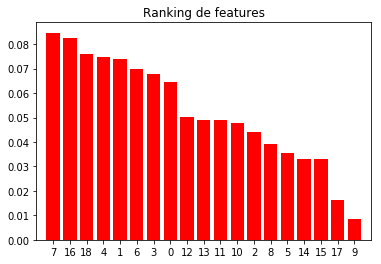

CPU times: user 320 ms, sys: 4 ms, total: 324 ms
Wall time: 316 ms


In [177]:
%%time
import matplotlib.pyplot as plt

importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

print("Ranking de features:")
for f in range(X.shape[1]):
    print("%d. feature %d (%f) columna %s" % (f + 1, indices[f], importances[indices[f]], train_df.drop(['person'], axis=1).columns[indices[f]]))

plt.figure()
plt.title("Ranking de features")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

# Entrenamiento

In [178]:
persons.set_index('person', inplace=True)
persons.head(1)

cant_eventos  duracion_sesion  days_since_first_event  \
person                                                            
4886f805             9             1388                      13   

          hours_since_first_event  minutes_since_first_event  \
person                                                         
4886f805                      335                      20152   

          days_since_last_event  hours_since_last_event  \
person                                                    
4886f805                     13                     335   

          minutes_since_last_event  count_events_last_week  \
person                                                       
4886f805                     20129                       0   

          count_conversions_last_week  count_most_common_model_views  \
person                                                                 
4886f805                            0                              4   

          count_most_common_storage_views  count_most_common_condition_views  \
person                                                                         
4886f805                                4                                  3   

          count_most_common_color_views  \
person                                    
4886f805                              4   

          count_most_common_device_type_visited  count_returned_to_site  \
person                                                                    
4886f805                                      1                       0   

          cant_checkout_events  device_type_mean_label  model_mean_label  
person                                                                    
4886f805                     1                     0.0               0.0

In [179]:
xCols = persons.columns
X = persons[xCols]

In [180]:
X.dtypes

cant_eventos                               int64
duracion_sesion                            int64
days_since_first_event                     int64
hours_since_first_event                    int64
minutes_since_first_event                  int64
days_since_last_event                      int64
hours_since_last_event                     int64
minutes_since_last_event                   int64
count_events_last_week                     int64
count_conversions_last_week                int64
count_most_common_model_views              int64
count_most_common_storage_views            int64
count_most_common_condition_views          int64
count_most_common_color_views              int64
count_most_common_device_type_visited      int64
count_returned_to_site                     int64
cant_checkout_events                       int64
device_type_mean_label                   float64
model_mean_label                         float64
dtype: object

In [182]:
labels = pd.read_csv("all/labels_training_set.csv")
print(len(labels))
X.reset_index(inplace=True)
X.head(1)

19414


person  cant_eventos  duracion_sesion  days_since_first_event  \
0  4886f805             9             1388                      13   

   hours_since_first_event  minutes_since_first_event  days_since_last_event  \
0                      335                      20152                     13   

   hours_since_last_event  minutes_since_last_event  count_events_last_week  \
0                     335                     20129                       0   

   count_conversions_last_week  count_most_common_model_views  \
0                            0                              4   

   count_most_common_storage_views  count_most_common_condition_views  \
0                                4                                  3   

   count_most_common_color_views  count_most_common_device_type_visited  \
0                              4                                      1   

   count_returned_to_site  cant_checkout_events  device_type_mean_label  \
0                       0                     1                     0.0   

   model_mean_label  
0               0.0

In [183]:
XN = pd.merge(X, labels, left_on='person', right_on='person', how='inner')

In [184]:
XN.columns

Index(['person', 'cant_eventos', 'duracion_sesion', 'days_since_first_event',
       'hours_since_first_event', 'minutes_since_first_event',
       'days_since_last_event', 'hours_since_last_event',
       'minutes_since_last_event', 'count_events_last_week',
       'count_conversions_last_week', 'count_most_common_model_views',
       'count_most_common_storage_views', 'count_most_common_condition_views',
       'count_most_common_color_views',
       'count_most_common_device_type_visited', 'count_returned_to_site',
       'cant_checkout_events', 'device_type_mean_label', 'model_mean_label',
       'label'],
      dtype='object')

In [185]:
print('Longitud total:', len(XN))
print('Cantidad de nulos:', XN['label'].isna().sum())
XN.head(1)

Longitud total: 19414
Cantidad de nulos: 0


person  cant_eventos  duracion_sesion  days_since_first_event  \
0  ad93850f            65           687632                      17   

   hours_since_first_event  minutes_since_first_event  days_since_last_event  \
0                      408                      24489                      9   

   hours_since_last_event  minutes_since_last_event  count_events_last_week  \
0                     217                     13029                       0   

   ...    count_most_common_model_views  count_most_common_storage_views  \
0  ...                               17                               10   

   count_most_common_condition_views  count_most_common_color_views  \
0                                  8                              8   

   count_most_common_device_type_visited  count_returned_to_site  \
0                                      5                       4   

   cant_checkout_events  device_type_mean_label  model_mean_label  label  
0                     1                0.036294          0.055458      0  

[1 rows x 21 columns]

In [186]:
XN['label'].value_counts()

0    18434
1      980
Name: label, dtype: int64

(1951, 21)


person  cant_eventos  duracion_sesion  days_since_first_event  \
7   d73ae9ef            17              574                      13   
10  43790d8f            76           950732                      13   
16  9bb3af27            59            94309                      14   
19  fc278339           408          4669514                      58   
21  c31d0174           349          7088939                      85   

    hours_since_first_event  minutes_since_first_event  days_since_last_event  \
7                       335                      20132                     13   
10                      335                      20149                      2   
16                      342                      20563                     13   
19                     1395                      83727                      4   
21                     2041                     122461                      2   

    hours_since_last_event  minutes_since_last_event  count_events_last_week  \
7                      335                     20122                       0   
10                      71                      4303                       3   
16                     316                     18991                       0   
19                      98                      5902                      30   
21                      71                      4312                      34   

    ...    count_most_common_model_views  count_most_common_storage_views  \
7   ...                                5                                5   
10  ...                               14                               33   
16  ...                                4                                9   
19  ...                               19                               64   
21  ...                               63                               70   

    count_most_common_condition_views  count_most_common_color_views  \
7                                   5                              2   
10                                 35                             15   
16                                 15                              8   
19                                 90                             41   
21                                100                             45   

    count_most_common_device_type_visited  count_returned_to_site  \
7                                       1                       0   
10                                      2                       1   
16                                      4                       3   
19                                     37                      64   
21                                     43                      44   

    cant_checkout_events  device_type_mean_label  model_mean_label  label  
7                      1                0.036294          0.055458      0  
10                     2                0.036294          0.049231      1  
16                     0                0.036294          0.110345      1  
19                     4                0.068266          0.040650      1  
21                     2                0.036294          0.034321      1  

[5 rows x 21 columns]

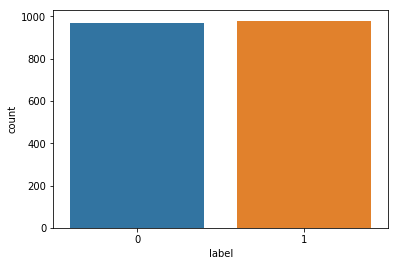

In [187]:
size = 0.05
undersample = pd.Index(np.random.choice(XN.loc[XN['label'] == 0].index.values, size=round(len(XN.index.values) * size), replace=False))
undersample = undersample.union(XN.loc[XN['label'] == 1].index)
undersample = pd.DataFrame({'person': undersample})
undersample = undersample.set_index('person')
#undersample
undersample = undersample.merge(XN, how='inner', left_index=True, right_index=True)
print(undersample.shape)

sns.countplot('label', data=undersample)
undersample.head()

In [188]:
print(len(undersample))
undersample['label'].value_counts()

1951


1    980
0    971
Name: label, dtype: int64

In [189]:
XN = undersample

In [190]:
XN.set_index('person', inplace=True)
XN.head(1)

cant_eventos  duracion_sesion  days_since_first_event  \
person                                                            
d73ae9ef            17              574                      13   

          hours_since_first_event  minutes_since_first_event  \
person                                                         
d73ae9ef                      335                      20132   

          days_since_last_event  hours_since_last_event  \
person                                                    
d73ae9ef                     13                     335   

          minutes_since_last_event  count_events_last_week  \
person                                                       
d73ae9ef                     20122                       0   

          count_conversions_last_week  count_most_common_model_views  \
person                                                                 
d73ae9ef                            0                              5   

          count_most_common_storage_views  count_most_common_condition_views  \
person                                                                         
d73ae9ef                                5                                  5   

          count_most_common_color_views  \
person                                    
d73ae9ef                              2   

          count_most_common_device_type_visited  count_returned_to_site  \
person                                                                    
d73ae9ef                                      1                       0   

          cant_checkout_events  device_type_mean_label  model_mean_label  \
person                                                                     
d73ae9ef                     1                0.036294          0.055458   

          label  
person           
d73ae9ef      0

In [191]:
xCols = XN.columns[:-1]
yCols = XN.columns[-1]
X = XN[xCols]
y = XN[yCols]

In [192]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=0)

### **Random Forests**

In [193]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [194]:
%%time
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=1000, criterion="gini", max_depth=100, min_samples_split=4, random_state= 0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

CPU times: user 3.79 s, sys: 0 ns, total: 3.79 s
Wall time: 3.79 s


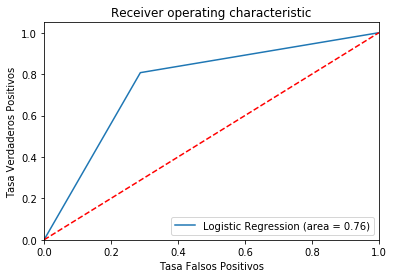

CPU times: user 208 ms, sys: 4 ms, total: 212 ms
Wall time: 213 ms


In [195]:
%%time
import matplotlib.pyplot as plt
# Evaluamos el modelo
logit_roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa Falsos Positivos')
plt.ylabel('Tasa Verdaderos Positivos')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [196]:
accuracy = metrics.accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 75.77%


# Merge con Test

In [197]:
testDf.fillna(0, inplace=True)
testDf.describe()

cant_eventos  duracion_sesion  days_since_first_event  \
count  19415.000000     1.941500e+04            19415.000000   
mean      60.252125     1.335851e+06               24.492145   
std      122.160096     2.535866e+06               32.088079   
min        1.000000     0.000000e+00                0.000000   
25%       10.000000     3.795000e+02                6.000000   
50%       25.000000     8.895000e+04               12.000000   
75%       62.000000     1.277538e+06               26.000000   
max     4438.000000     1.289404e+07              150.000000   

       hours_since_first_event  minutes_since_first_event  \
count             19415.000000               19415.000000   
mean                597.173629               35859.903219   
std                 770.117067               46207.205004   
min                   0.000000                   1.000000   
25%                 150.000000                9035.000000   
50%                 311.000000               18696.000000   
75%                 634.000000               38092.000000   
max                3615.000000              216950.000000   

       days_since_last_event  hours_since_last_event  \
count           19415.000000            19415.000000   
mean                9.044141              226.105228   
std                14.770751              354.800667   
min                 0.000000                0.000000   
25%                 2.000000               48.000000   
50%                 6.000000              152.000000   
75%                11.000000              287.000000   
max               150.000000             3600.000000   

       minutes_since_last_event  count_events_last_week  \
count              19415.000000            19415.000000   
mean               13595.714448               15.491424   
std                21288.198221               34.765239   
min                    0.000000                0.000000   
25%                 2888.000000                0.000000   
50%                 9132.000000                3.000000   
75%                17269.500000               17.000000   
max               216003.000000              653.000000   

       count_conversions_last_week  count_most_common_model_views  \
count                 19415.000000                   19415.000000   
mean                      0.047644                      12.436518   
std                       0.290551                      24.483221   
min                       0.000000                       0.000000   
25%                       0.000000                       2.000000   
50%                       0.000000                       5.000000   
75%                       0.000000                      13.000000   
max                      11.000000                     622.000000   

       count_most_common_storage_views  count_most_common_condition_views  \
count                     19415.000000                       19415.000000   
mean                         18.118671                          16.821942   
std                          39.780064                          37.368441   
min                           0.000000                           0.000000   
25%                           2.000000                           2.000000   
50%                           6.000000                           6.000000   
75%                          18.000000                          17.000000   
max                        1043.000000                        1055.000000   

       count_most_common_color_views  count_most_common_device_type_visited  \
count                   19415.000000                           19415.000000   
mean                       13.226114                               5.033840   
std                        28.072658                               9.471903   
min                         0.000000                               0.000000   
25%                         2.000000                               1.000000   
50%                         5.000000                 

In [198]:
testDf.set_index('person', inplace=True)
testDf.head(1)

cant_eventos  duracion_sesion  days_since_first_event  \
person                                                            
4886f805             9             1388                      13   

          hours_since_first_event  minutes_since_first_event  \
person                                                         
4886f805                      335                      20152   

          days_since_last_event  hours_since_last_event  \
person                                                    
4886f805                     13                     335   

          minutes_since_last_event  count_events_last_week  \
person                                                       
4886f805                     20129                       0   

          count_conversions_last_week  count_most_common_model_views  \
person                                                                 
4886f805                            0                              4   

          count_most_common_storage_views  count_most_common_condition_views  \
person                                                                         
4886f805                                4                                  3   

          count_most_common_color_views  \
person                                    
4886f805                              4   

          count_most_common_device_type_visited  count_returned_to_site  \
person                                                                    
4886f805                                      1                       0   

          cant_checkout_events  device_type_mean_label  model_mean_label  
person                                                                    
4886f805                     1                     0.0               0.0

# Entrenamiento del modelo

In [199]:
from sklearn.model_selection import cross_val_score

clf.fit(X_train, y_train)
scores = cross_val_score(clf, X_test, y_test, cv=5)
scores 

array([ 0.69491525,  0.76271186,  0.72881356,  0.70689655,  0.68965517])

**Metrica con roc_auc**

In [201]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, clf.predict(X_test))
print('FP:',false_positive_rate)
print('TP:', true_positive_rate)
print(auc(false_positive_rate, true_positive_rate)) # (kaggle: FP: 0.23, TP: 0.89)  
print(roc_auc_score(y_test, clf.predict(X_test))) # 0.827 (0.83 kaggle)

FP: [ 0.         0.2875817  1.       ]
TP: [ 0.          0.80714286  1.        ]
0.759780578898
0.759780578898


In [202]:
roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]) # kaggle: 0,879

0.80644257703081235

In [203]:
clf.score(X_test, y_test) #0,825 kaggle

0.75767918088737196

**Idem con Gradient Boosting**

In [1325]:
'''
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(n_estimators=10, learning_rate=0.23, subsample=0.4)
clf.fit(X_train, y_train)
scores = cross_val_score(clf, X_test, y_test, cv=5)
from sklearn.metrics import roc_curve, auc, roc_auc_score
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, clf.predict(X_test))
print(auc(false_positive_rate, true_positive_rate))
print(roc_auc_score(y_test, clf.predict(X_test))) # 0,74 (0.53 sin undersampling, 0.78 con undersampling)
print(roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])) # 0,83 (0.88 sin undersampling, 0.87 con undersampling)
print(clf.score(X_test, y_test)) #0,76 (0.947 sin undersampling, 0.80 con undersampling)
'''

0.76962150238
0.76962150238
0.882770231046
0.805017103763


# Submit entrega

In [204]:
xCols = XN.columns[:-1]
yCols = XN.columns[-1]
X = XN[xCols]
y = XN[yCols]
XN.head(1)

cant_eventos  duracion_sesion  days_since_first_event  \
person                                                            
d73ae9ef            17              574                      13   

          hours_since_first_event  minutes_since_first_event  \
person                                                         
d73ae9ef                      335                      20132   

          days_since_last_event  hours_since_last_event  \
person                                                    
d73ae9ef                     13                     335   

          minutes_since_last_event  count_events_last_week  \
person                                                       
d73ae9ef                     20122                       0   

          count_conversions_last_week  count_most_common_model_views  \
person                                                                 
d73ae9ef                            0                              5   

          count_most_common_storage_views  count_most_common_condition_views  \
person                                                                         
d73ae9ef                                5                                  5   

          count_most_common_color_views  \
person                                    
d73ae9ef                              2   

          count_most_common_device_type_visited  count_returned_to_site  \
person                                                                    
d73ae9ef                                      1                       0   

          cant_checkout_events  device_type_mean_label  model_mean_label  \
person                                                                     
d73ae9ef                     1                0.036294          0.055458   

          label  
person           
d73ae9ef      0

In [205]:
clf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=100, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=4,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [206]:
print(X.shape)
print(testDf.shape)
print(testDf.columns)
print(X.columns)

(1951, 19)
(19415, 19)
Index(['cant_eventos', 'duracion_sesion', 'days_since_first_event',
       'hours_since_first_event', 'minutes_since_first_event',
       'days_since_last_event', 'hours_since_last_event',
       'minutes_since_last_event', 'count_events_last_week',
       'count_conversions_last_week', 'count_most_common_model_views',
       'count_most_common_storage_views', 'count_most_common_condition_views',
       'count_most_common_color_views',
       'count_most_common_device_type_visited', 'count_returned_to_site',
       'cant_checkout_events', 'device_type_mean_label', 'model_mean_label'],
      dtype='object')
Index(['cant_eventos', 'duracion_sesion', 'days_since_first_event',
       'hours_since_first_event', 'minutes_since_first_event',
       'days_since_last_event', 'hours_since_last_event',
       'minutes_since_last_event', 'count_events_last_week',
       'count_conversions_last_week', 'count_most_common_model_views',
       'count_most_common_storage_views', 

In [210]:
# Version con el predict
#predictions = clf.predict(testDf)

# Con el predict_proba devuelve dos columnas: una para el 0 y otra para el 1
predictions = clf.predict_proba(testDf) 

In [211]:
predictions

array([[ 0.97153333,  0.02846667],
       [ 0.2368381 ,  0.7631619 ],
       [ 0.82383214,  0.17616786],
       ..., 
       [ 0.32139524,  0.67860476],
       [ 0.48067024,  0.51932976],
       [ 0.43738095,  0.56261905]])

In [212]:
print(len(predictions))

19415


In [213]:
'''
# Version para el predict
predictionsDf = pd.DataFrame(predictions)
predictionsDf.columns = ['label']
predictionsDf['label'].value_counts()
'''

"\n# Version para el predict\npredictionsDf = pd.DataFrame(predictions)\npredictionsDf.columns = ['label']\npredictionsDf['label'].value_counts()\n"

In [214]:
# Version para el predict_proba
predictionsDf = pd.DataFrame(predictions)
predictionsDf = predictionsDf[1]
predictionsDf = pd.DataFrame(predictionsDf)
predictionsDf.columns = ['label']
predictionsDf.head(3)

label
0  0.028467
1  0.763162
2  0.176168

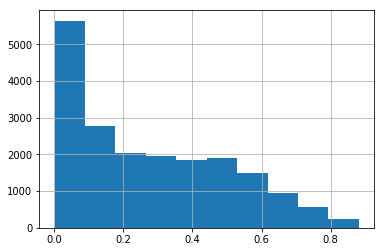

In [215]:
(predictionsDf['label']).hist()

In [216]:
testDf.reset_index(inplace=True)
predictionsDf = testDf.join(predictionsDf)
print(len(predictionsDf))
print(predictionsDf.shape)
predictionsDf.head(1)

19415
(19415, 21)


person  cant_eventos  duracion_sesion  days_since_first_event  \
0  4886f805             9             1388                      13   

   hours_since_first_event  minutes_since_first_event  days_since_last_event  \
0                      335                      20152                     13   

   hours_since_last_event  minutes_since_last_event  count_events_last_week  \
0                     335                     20129                       0   

     ...     count_most_common_model_views  count_most_common_storage_views  \
0    ...                                 4                                4   

   count_most_common_condition_views  count_most_common_color_views  \
0                                  3                              4   

   count_most_common_device_type_visited  count_returned_to_site  \
0                                      1                       0   

   cant_checkout_events  device_type_mean_label  model_mean_label     label  
0                     1                     0.0               0.0  0.028467  

[1 rows x 21 columns]

In [217]:
predictionsDf = predictionsDf[['person','label']]

In [218]:
predictionsDf.head(2)

person     label
0  4886f805  0.028467
1  0297fc1e  0.763162

In [220]:
print(predictionsDf.shape)
print(predictionsDf.columns)

(19415, 2)
Index(['person', 'label'], dtype='object')


In [221]:
predictionsDf.to_csv('submit.csv', index=False)